In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [131]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [132]:
file = "pima-indians-diabetes.data.csv"
df = pd.read_csv(file, header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.6,50,1
1,1,85,66,29,0,26.6,0.4,31,0
2,8,183,64,0,0,23.3,0.7,32,1
3,1,89,66,23,94,28.1,0.2,21,0
4,0,137,40,35,168,43.1,2.3,33,1


In [133]:
ndf = pd.DataFrame(preprocessing.normalize(df))
print(ndf.head())
# 11.
# The normalized data has more differences compared to the normal data.
# Normalization did not have as higher of an impact than standardization.
# Standardization had a bigger impact because it made it more even across the board.

         0    1    2    3    4    5        6    7        8
0  3.4e-02  0.8  0.4  0.2  0.0  0.2  3.5e-03  0.3  5.6e-03
1  8.4e-03  0.7  0.6  0.2  0.0  0.2  3.0e-03  0.3  0.0e+00
2  4.0e-02  0.9  0.3  0.0  0.0  0.1  3.4e-03  0.2  5.0e-03
3  6.6e-03  0.6  0.4  0.2  0.6  0.2  1.1e-03  0.1  0.0e+00
4  0.0e+00  0.6  0.2  0.2  0.7  0.2  1.0e-02  0.1  4.4e-03


In [134]:
sdf = pd.DataFrame(preprocessing.scale(df))
print(preprocessing.scale(df))

scaler = preprocessing.StandardScaler(copy=True, with_mean=False, with_std=True)
print(scaler.fit(sdf))
print(sdf.head())

[[ 0.63994726  0.84832379  0.14964075 ...  0.46849198  1.4259954
   1.36589591]
 [-0.84488505 -1.12339636 -0.16054575 ... -0.36506078 -0.19067191
  -0.73212021]
 [ 1.23388019  1.94372388 -0.26394125 ...  0.60439732 -0.10558415
   1.36589591]
 ...
 [ 0.3429808   0.00330087  0.14964075 ... -0.68519336 -0.27575966
  -0.73212021]
 [-0.84488505  0.1597866  -0.47073225 ... -0.37110101  1.17073215
   1.36589591]
 [-0.84488505 -0.8730192   0.04624525 ... -0.47378505 -0.87137393
  -0.73212021]]
StandardScaler(copy=True, with_mean=False, with_std=True)
     0    1    2    3    4    5    6        7    8
0  0.6  0.8  0.1  0.9 -0.7  0.2  0.5  1.4e+00  1.4
1 -0.8 -1.1 -0.2  0.5 -0.7 -0.7 -0.4 -1.9e-01 -0.7
2  1.2  1.9 -0.3 -1.3 -0.7 -1.1  0.6 -1.1e-01  1.4
3 -0.8 -1.0 -0.2  0.2  0.1 -0.5 -0.9 -1.0e+00 -0.7
4 -1.1  0.5 -1.5  0.9  0.8  1.4  5.5 -2.0e-02  1.4


In [135]:
diabetes = df.loc[df[8] == 1]
print(diabetes.head())

without_diabetes = df.loc[df[8] == 0]
print(without_diabetes.head())

   0    1   2   3    4     5    6   7  8
0  6  148  72  35    0  33.6  0.6  50  1
2  8  183  64   0    0  23.3  0.7  32  1
4  0  137  40  35  168  43.1  2.3  33  1
6  3   78  50  32   88  31.0  0.2  26  1
8  2  197  70  45  543  30.5  0.2  53  1
     0    1   2   3   4     5    6   7  8
1    1   85  66  29   0  26.6  0.4  31  0
3    1   89  66  23  94  28.1  0.2  21  0
5    5  116  74   0   0  25.6  0.2  30  0
7   10  115   0   0   0  35.3  0.1  29  0
10   4  110  92   0   0  37.6  0.2  30  0


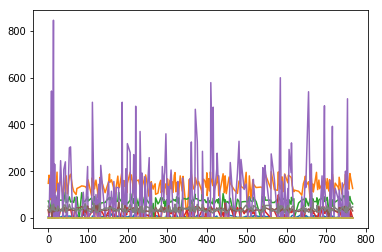

In [136]:
plt.plot(diabetes)

In [137]:
array = df.values
ndf_array = ndf.values
sdf_array = sdf.values
X = array[:,0:7]
Y = array[:,8]
ndfX = ndf_array[:,0:7]
ndfY = ndf_array[:,8]
sdfX = sdf_array[:,0:7]
sdfY = sdf_array[:,8]

df.head(20)

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.6,50,1
1,1,85,66,29,0,26.6,0.4,31,0
2,8,183,64,0,0,23.3,0.7,32,1
3,1,89,66,23,94,28.1,0.2,21,0
4,0,137,40,35,168,43.1,2.3,33,1
5,5,116,74,0,0,25.6,0.2,30,0
6,3,78,50,32,88,31.0,0.2,26,1
7,10,115,0,0,0,35.3,0.1,29,0
8,2,197,70,45,543,30.5,0.2,53,1
9,8,125,96,0,0,0.0,0.2,54,1


In [138]:
pd.set_option('display.width', 100)
pd.set_option('precision', 1)
description = df.describe()
ndf_description = ndf.describe()
sdf_description = sdf.describe()
print(description)
print(ndf_description)
print(sdf_description)

# 5.
#This data is good for looking at the individual values for each of the predictors in the particular data.
#You can look and see what the mean, standard deviation, minimum, maximum, etc for each of the different collumns.

           0      1      2      3      4      5        6      7      8
count  768.0  768.0  768.0  768.0  768.0  768.0  7.7e+02  768.0  768.0
mean     3.8  120.9   69.1   20.5   79.8   32.0  4.7e-01   33.2    0.3
std      3.4   32.0   19.4   16.0  115.2    7.9  3.3e-01   11.8    0.5
min      0.0    0.0    0.0    0.0    0.0    0.0  7.8e-02   21.0    0.0
25%      1.0   99.0   62.0    0.0    0.0   27.3  2.4e-01   24.0    0.0
50%      3.0  117.0   72.0   23.0   30.5   32.0  3.7e-01   29.0    0.0
75%      6.0  140.2   80.0   32.0  127.2   36.6  6.3e-01   41.0    1.0
max     17.0  199.0  122.0   99.0  846.0   67.1  2.4e+00   81.0    1.0
             0      1      2        3      4        5        6        7        8
count  7.7e+02  768.0  768.0  7.7e+02  768.0  7.7e+02  7.7e+02  7.7e+02  7.7e+02
mean   2.3e-02    0.7    0.4  1.1e-01    0.3  1.9e-01  2.7e-03  2.0e-01  1.8e-03
std    2.1e-02    0.2    0.2  9.3e-02    0.3  6.3e-02  1.9e-03  8.1e-02  2.6e-03
min    0.0e+00    0.0    0.0  0.0e+00

<Figure size 432x288 with 0 Axes>

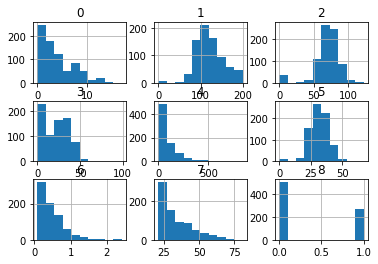

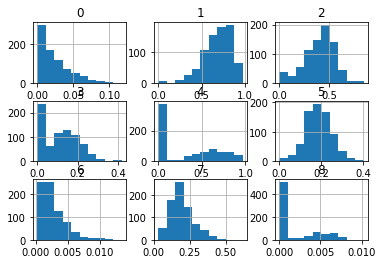

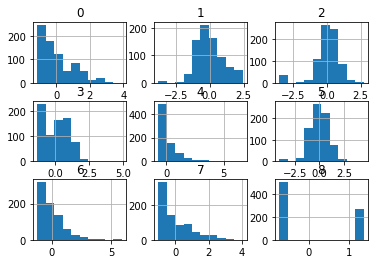

In [139]:
plt.figure()
df.hist()
ndf.hist()
sdf.hist()
plt.show()

# 6.
#You can see the distribusions for each of the collumns on the different models, regular, normalized, and standardized.
#The distributions for the different models look similar for the different collumns but there are some variations between them.
#The standardized and normal distributions look similar and show that there was not that much that changed.

<Figure size 432x288 with 0 Axes>

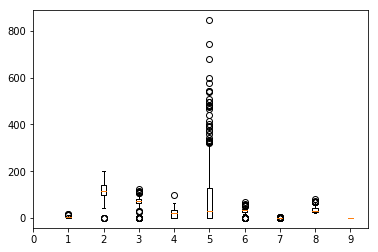

<Figure size 432x288 with 0 Axes>

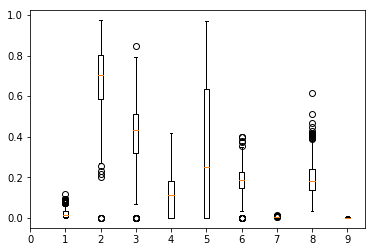

<Figure size 432x288 with 0 Axes>

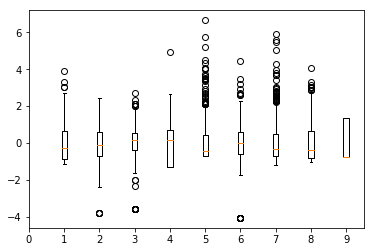

In [140]:
plt.figure()
fig, ax = plt.subplots()
for n, col in enumerate(df.columns):
    ax.boxplot(df[col], positions=[n+1])

ax.set_xticks(range(10))
ax.set_xticklabels(range(10))
plt.show()

plt.figure()
fig, ax = plt.subplots()
for n, col in enumerate(ndf.columns):
    ax.boxplot(ndf[col], positions=[n+1])

ax.set_xticks(range(10))
ax.set_xticklabels(range(10))
plt.show()

plt.figure()
fig, ax = plt.subplots()
for n, col in enumerate(sdf.columns):
    ax.boxplot(sdf[col], positions=[n+1])

ax.set_xticks(range(10))
ax.set_xticklabels(range(10))
plt.show()

# 7.
# Both the normal data and the standardized data have outliers at 5, however the standardized skews much less
# The Normalized data has a lot more even data across the board

In [141]:
plt.figure()
corMat = df.corr(method='pearson')
ndf_corMat = ndf.corr(method='pearson')
sdf_corMat = sdf.corr(method='pearson')
print(corMat)
print(ndf_corMat)
print(sdf_corMat)

         0        1        2        3        4        5        6        7        8
0  1.0e+00  1.3e-01  1.4e-01 -8.2e-02 -7.4e-02  1.8e-02 -3.4e-02  5.4e-01  2.2e-01
1  1.3e-01  1.0e+00  1.5e-01  5.7e-02  3.3e-01  2.2e-01  1.4e-01  2.6e-01  4.7e-01
2  1.4e-01  1.5e-01  1.0e+00  2.1e-01  8.9e-02  2.8e-01  4.1e-02  2.4e-01  6.5e-02
3 -8.2e-02  5.7e-02  2.1e-01  1.0e+00  4.4e-01  3.9e-01  1.8e-01 -1.1e-01  7.5e-02
4 -7.4e-02  3.3e-01  8.9e-02  4.4e-01  1.0e+00  2.0e-01  1.9e-01 -4.2e-02  1.3e-01
5  1.8e-02  2.2e-01  2.8e-01  3.9e-01  2.0e-01  1.0e+00  1.4e-01  3.6e-02  2.9e-01
6 -3.4e-02  1.4e-01  4.1e-02  1.8e-01  1.9e-01  1.4e-01  1.0e+00  3.4e-02  1.7e-01
7  5.4e-01  2.6e-01  2.4e-01 -1.1e-01 -4.2e-02  3.6e-02  3.4e-02  1.0e+00  2.4e-01
8  2.2e-01  4.7e-01  6.5e-02  7.5e-02  1.3e-01  2.9e-01  1.7e-01  2.4e-01  1.0e+00
         0        1        2        3    4        5        6        7        8
0  1.0e+00  2.0e-01  2.0e-01 -9.5e-02 -0.4  1.8e-01  1.2e-02  5.6e-01  1.7e-01
1  2.0e-01  

<Figure size 432x288 with 0 Axes>

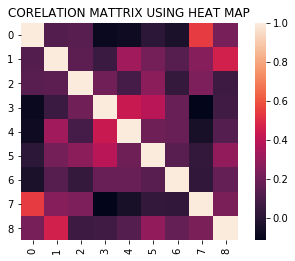

In [142]:
sns.heatmap(corMat, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("CORELATION MATTRIX USING HEAT MAP")
plt.show()

<Figure size 432x288 with 0 Axes>

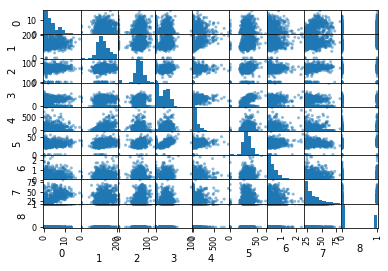

<Figure size 432x288 with 0 Axes>

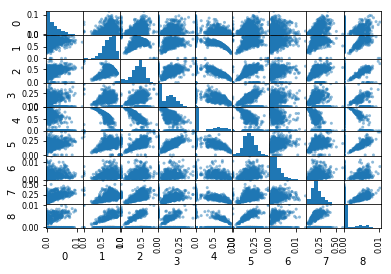

<Figure size 432x288 with 0 Axes>

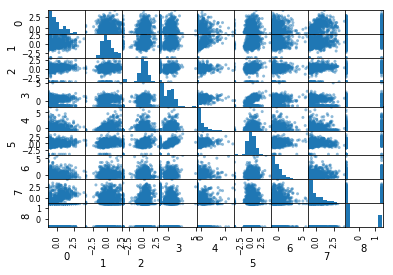

In [143]:
plt.figure()
pd.plotting.scatter_matrix(df)
plt.show()

plt.figure()
pd.plotting.scatter_matrix(ndf)
plt.show()

plt.figure()
pd.plotting.scatter_matrix(sdf)
plt.show()

In [144]:
X1 = df.drop(df.columns[8], axis = 1)
# Converting last column to a list 
Y1 = df[8].tolist()

result = stepwise_selection(X1, Y1)
print("Resulting Features")
print(result)

Add                               1 with p-value 8.93543e-43
Add                               5 with p-value 7.69597e-10
Add                               0 with p-value 9.52526e-08
Add                               6 with p-value 0.00137653
Add                               2 with p-value 0.00825556
Resulting Features
[1, 5, 0, 6, 2]


C:\Users\azzbu_000\Miniconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


In [145]:
NUM_FEATURES = 5
model = linear_model.LinearRegression()
rfe = RFE(model, NUM_FEATURES)
fit = rfe.fit(X,Y)
print("Num Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_)

NUM_FEATURES = 5
model = linear_model.LinearRegression()
rfe = RFE(model, NUM_FEATURES)
fit = rfe.fit(ndfX,ndfY)
print("Num Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_)

NUM_FEATURES = 5
model = linear_model.LinearRegression()
rfe = RFE(model, NUM_FEATURES)
fit = rfe.fit(sdfX,sdfY)
print("Num Features:", fit.n_features_)
print("Selected Features:", fit.support_)
print("Feature Ranking:", fit.ranking_)

Num Features:  5
Selected Features:  [ True  True  True False False  True  True]
Feature Ranking:  [1 1 1 3 2 1 1]
Num Features:  5
Selected Features:  [ True False  True False  True  True  True]
Feature Ranking:  [1 2 1 3 1 1 1]
Num Features: 5
Selected Features: [ True  True  True False False  True  True]
Feature Ranking: [1 1 1 3 2 1 1]
